The following is adapted from [Visualizing TensorFlow Graphs in Jupyter Notebooks](https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html)

And excuted in

```bash
docker run -it -p 8888:8888 -p 6006:6006 -v `pwd`:/space/ -w /space/ --rm --name md waleedka/modern-deep-learning jupyter notebook --ip=0.0.0.0 --allow-root
```

In [1]:
import tensorflow as tf

g = tf.Graph()

with g.as_default():
    a = tf.placeholder(tf.float32, name="a")
    b = tf.placeholder(tf.float32, name="b")
    c = a + b

In [2]:
[node.name for node in g.as_graph_def().node]

['a', 'b', 'add']

In [3]:
g.as_graph_def().node[2].input

['a', 'b']

In [14]:
%%bash
export DEBIAN_FRONTEND=noninteractive
apt-get update
apt-get install -yq --no-install-recommends graphviz

Hit:1 http://archive.ubuntu.com/ubuntu xenial InRelease
Get:2 http://security.ubuntu.com/ubuntu xenial-security InRelease [102 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [102 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [102 kB]
Fetched 306 kB in 2s (123 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-12ubuntu2.1).
0 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.


In [6]:
%%bash
pip install graphviz

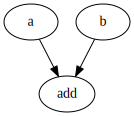

In [15]:
from graphviz import Digraph

dot = Digraph()

for n in g.as_graph_def().node:
    # Each node has a name and a label. The name identifies the node
    # while the label is what will be displayed in the graph.
    # We're using the name as a label for simplicity.
    dot.node(n.name, label=n.name)
    
    for i in n.input:
        # Edges are determined by the names of the nodes
        dot.edge(i, n.name)
        
# Jupyter can automatically display the DOT graph,
# which allows us to just return it as a value.
dot

In [16]:
def tf_to_dot(graph):
    dot = Digraph()

    for n in g.as_graph_def().node:
        dot.node(n.name, label=n.name)

        for i in n.input:
            dot.edge(i, n.name)
            
    return dot

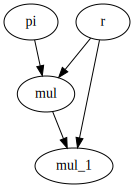

In [17]:
g = tf.Graph()

with g.as_default():
    pi = tf.constant(3.14, name="pi")
    r = tf.placeholder(tf.float32, name="r")
    
    y = pi * r * r
    
tf_to_dot(g)

In [24]:
%%bash
mkdir vis_logs

Run the follwing:

```bash
docker exec -it md tensorboard --logdir=dl/vis_logs
```

And navigate to http://localhost:6006/#graphs

In [26]:
g = tf.Graph()

with g.as_default():
    pi = tf.constant(3.14, name="pi")
    r = tf.placeholder(tf.float32, name="r")
    
    y = pi * r * r
    
tf.summary.FileWriter("vis_logs", g).close()

![](https://i.imgur.com/XajS4Tv.png)

In [27]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32, name="X")
    
    W1 = tf.placeholder(tf.float32, name="W1")
    b1 = tf.placeholder(tf.float32, name="b1")
    
    a1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    W2 = tf.placeholder(tf.float32, name="W2")
    b2 = tf.placeholder(tf.float32, name="b2")
    
    a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)

    W3 = tf.placeholder(tf.float32, name="W3")
    b3 = tf.placeholder(tf.float32, name="b3")
    
    y_hat = tf.matmul(a2, W3) + b3
    
tf.summary.FileWriter("vis_logs", g).close()

![](https://i.imgur.com/pwcEAgb.png)

In [30]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32, name="X")
    
    with tf.name_scope("Layer1"):
        W1 = tf.placeholder(tf.float32, name="W1")
        b1 = tf.placeholder(tf.float32, name="b1")

        a1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    with tf.name_scope("Layer2"):
        W2 = tf.placeholder(tf.float32, name="W2")
        b2 = tf.placeholder(tf.float32, name="b2")

        a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)

    with tf.name_scope("Layer3"):
        W3 = tf.placeholder(tf.float32, name="W3")
        b3 = tf.placeholder(tf.float32, name="b3")

        y_hat = tf.matmul(a2, W3) + b3
    
tf.summary.FileWriter("vis_logs", g).close()

![](https://i.imgur.com/6HIpspV.png)

In [33]:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [32]:
# Simply call this to display the result. Unfortunately it doesn't save the output together with
# the Jupyter notebook, so we can only show a non-interactive image here.
show_graph(g)

The following is adapted from [Visualizing CNN architectures side by side with mxnet](http://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/)

In [36]:
%%bash
pip install mxnet

In [48]:
%%bash
# https://github.com/dmlc/mxnet-model-gallery/blob/master/imagenet-1k-vgg.md
wget http://data.dmlc.ml/mxnet/models/imagenet/vgg/vgg19.tar.gz

--2017-11-24 00:26:22--  http://data.dmlc.ml/mxnet/models/imagenet/vgg/vgg19.tar.gz
Resolving data.dmlc.ml (data.dmlc.ml)... 54.208.175.7
Connecting to data.dmlc.ml (data.dmlc.ml)|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2017-11-24 00:26:25 ERROR 404: Not Found.



In [45]:
%%bash
wget http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN-symbol.json

--2017-11-23 01:55:04--  http://data.dmlc.ml/models/imagenet/inception-bn/Inception-BN-symbol.json
Resolving data.dmlc.ml (data.dmlc.ml)... 54.208.175.7
Connecting to data.dmlc.ml (data.dmlc.ml)|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116922 (114K) [application/json]
Saving to: 'Inception-BN-symbol.json'

     0K .......... .......... .......... .......... .......... 43% 23.1K 3s
    50K .......... .......... .......... .......... .......... 87% 16.4K 1s
   100K .......... ....                                       100% 10.2K=6.6s

2017-11-23 01:55:13 (17.3 KB/s) - 'Inception-BN-symbol.json' saved [116922/116922]



In [46]:
%%bash
cat Inception-BN-symbol.json

{
  "nodes": [
    {
      "op": "null", 
      "param": {}, 
      "name": "data", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "conv_1_weight", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "conv_1_bias", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "Convolution", 
      "param": {
        "cudnn_off": "False", 
        "cudnn_tune": "off", 
        "dilate": "(1,1)", 
        "kernel": "(7,7)", 
        "no_bias": "False", 
        "num_filter": "64", 
        "num_group": "1", 
        "pad": "(3,3)", 
        "stride": "(2,2)", 
        "workspace": "1024"
      }, 
      "name": "conv_1", 
      "inputs": [[0, 0], [1, 0], [2, 0]], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "bn_1_gamma", 
      "inputs": [], 
      "backward_source_id": -1


In [49]:
%%bash
wget http://data.dmlc.ml/mxnet/models/imagenet/resnet/50-layers/resnet-50-symbol.json && wget http://data.dmlc.ml/mxnet/models/imagenet/resnet/50-layers/resnet-50-0000.params

Process is interrupted.


In [51]:
import mxnet as mx

sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

# name = "inception-v3"
# net = importlib.import_module("symbol_" + name).get_symbol(2)
# a = mx.viz.plot_network(net, shape={"data":(1, 1, 299, 299)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(name)

# sym, arg_params, aux_params = mx.model.load_checkpoint('Inception-BN', 0)

In [ ]:
pltn = mx.viz.plot_network(sym, shape = {'data': (1, 3, 224, 224)}, \
node_attrs = {'shape': 'oval', 'fixedsize': 'false'})
pltn.view('resnet-50')